## Sandox for Developing Resnet
Notes, ideas, and general approach to building Resnet from the ground up.

## General Approach

fastai for data handling and training, pytorch for architecure. 

1. Use fast.ai for downloading data / preprocessing / loading / augmentations etc.
- Unroll and practice NN building and training loops
- Create a basic neural network to run through MNIST using pytorch
- Create a loss function and visualize training and metrics using fast.ai
- Create a better neural network with multiple layers and convolutions in pytorch
- Download imagenet
- Create VGG
- Create ResNet
- Create wide ResNet 
- Download COCO
- Try training only on COCO
- Try training on Imagenet, then COCO
- Try making final Detectron Wide Resnet
- Clean up and put into module for use as backbone for any future projects

In [23]:
from fastai.callback import *
from fastai.vision import *
from fastai.datasets import *

## MNIST

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/home/sudosharma/.fastai/data/mnist_sample')

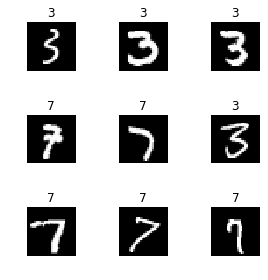

In [3]:
data = ImageDataBunch.from_folder(path)
data.show_batch(rows=3, figsize=(4, 4))

## NN v1

In [10]:
model = simple_cnn((3, 16, 16, 2))
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.122964,0.090500,0.967615,00:00


## NN v2

In [12]:
model = models.resnet50
learn = create_cnn(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.129294,0.069982,0.973994,00:04


## NN v3

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 256, 3, 1), nn.ReLU(True),
    nn.Conv2d(256, 128, 3, 1), nn.ReLU(True),
    nn.Conv2d(128, 64, 3, 1), nn.ReLU(True),
    nn.AdaptiveMaxPool2d(1),
    Flatten()
)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.136543,0.088018,0.967615,00:01
